# Assignment 3: Identifying the outliers using spectral clustering


# Team 
- Rahul Vigneswaran K | CS23MTECH02002
- SarveshKumar Purohit | AI22MTECH14006
- Rithik Agarwal | CS22MTECH11004
- Vinayak Nambiar | AI22MTECH13005
- Roshin Roy | AI22MTECH13006
- Parth Nitesh Thakkar | CS22MTECH14005



In [ ]:
import pandas as pd
from sklearn import preprocessing, neighbors
from scipy.spatial import distance
import numpy as np
import  matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity, laplacian_kernel
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from scipy.linalg import sqrtm, inv

import seaborn as sns

In [ ]:
df = pd.read_csv('data.csv')

df

,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
0,0.997797,0.999888,0.215934,0.196713,0.000000,0.955616,0.998810,-0.032581,1.761759,-0.054329
1,0.994004,0.979902,-0.337135,-0.248634,0.000000,0.640812,0.553918,-0.032026,-0.629311,-0.053516
2,0.947603,0.455667,0.001743,0.128610,-0.004054,-0.162069,0.960601,-0.030209,1.535697,-0.054215
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126
4,0.999893,0.327615,0.700477,0.315601,0.000000,0.300785,0.979009,-0.032224,1.762049,-0.054330
...,...,...,...,...,...,...,...,...,...,...
1194,1.000000,0.670847,0.566994,0.325485,0.000000,0.263078,0.211872,-0.030984,-1.053454,-0.004980
1195,0.999503,0.994784,0.847388,0.807294,0.000000,0.992071,0.779629,-0.032152,-0.867659,-0.051979
1196,0.999999,0.751775,-0.209639,-0.052031,0.000000,0.818428,0.850427,-0.032923,-0.517706,-0.053754
1197,0.999992,0.997277,0.199312,0.190436,0.000000,0.534354,0.119579,-0.032986,-1.031108,-0.043029


In [ ]:
df.max() - df.min()

cov1                     1.312219
cov2                     1.531958
cov3                     1.818128
cov4                     1.818173
cov5                     1.718818
cov6                     1.682733
cov7                     1.859529
sal_pur_rat             34.402508
igst_itc_tot_itc_rat     3.244385
lib_igst_itc_rat        33.242725
dtype: float64

In [ ]:
data = df.to_numpy()

## Step 1: Preprocessing dataset

In [ ]:
data = preprocessing.normalize(data)
data.shape

(1199, 10)

## Step 2: Compute similarity matrix/ Adjacency matrix, degree matrix and laplacian matrix

In [ ]:
'''
    Affinity matrix/ similarity matrix is computed using rbf kernel. 
    Please note that trials were also conducted with laplacian kernel and same number of cluster was obtained.
'''

similarity_matrix = rbf_kernel(data)          # Can use any other kernel

In [ ]:
similarity_matrix

array([[1.        , 0.88662621, 0.97642127, ..., 0.90505529, 0.84885542,
        0.84300035],
       [0.88662621, 1.        , 0.85499945, ..., 0.99269895, 0.97515715,
        0.980384  ],
       [0.97642127, 0.85499945, 1.        , ..., 0.87085581, 0.81350301,
        0.80010737],
       ...,
       [0.90505529, 0.99269895, 0.87085581, ..., 1.        , 0.96593835,
        0.97415359],
       [0.84885542, 0.97515715, 0.81350301, ..., 0.96593835, 1.        ,
        0.97941842],
       [0.84300035, 0.980384  , 0.80010737, ..., 0.97415359, 0.97941842,
        1.        ]])

### P. Yang et. al. (***'A Spectral Clustering Algorithm for Outlier Detection'***) suggests a methodology to reduce the computation time complexity by making the adjacency matrix sparse by limiting the number of neighborhoods to a set of nodes with high similarity values by using a threshold to neglect low similarity neighborhoods. This threshold according to the paper lies in the interval;

### <center>[$\mu$ - $\sigma$, $\mu$)</center>


### This will help in isolating outliers and constuct a sparse matrix

In [ ]:
# Computing mean and std dev for deciding threshold value.

mean = np.mean(similarity_matrix)
std_dev = np.std(similarity_matrix)

threshold_range = (mean-std_dev, mean)
threshold_range

(0.8752291966882527, 0.926382228806645)

In [ ]:
# Defining threshold and computing discretized adjacency matrix

threshold = 0.9

adj_matrix = np.zeros((similarity_matrix.shape[0], similarity_matrix.shape[1]))

for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        if i == j:
            adj_matrix[i][j] = 0
        else:
            adj_matrix[i][j] = 1 if similarity_matrix[i][j] >= threshold else 0

In [ ]:
# Display dicretized Adjacency matrix

adj_matrix

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 1., 0.]])

In [ ]:
G = nx.Graph(adj_matrix)

In [ ]:
G.number_of_edges()

511739

In [ ]:
# Computing degree matrix

deg_matrix = np.diag(np.sum(adj_matrix, axis=1))

deg_matrix

array([[ 640.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,  950.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,  495., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ..., 1014.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,  874.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,  818.]])

In [ ]:
# Computing normalised Laplacian matrix

I = np.identity(len(adj_matrix))

norm_laplacian = I - ((sqrtm(inv(deg_matrix))).dot(adj_matrix)).dot(sqrtm(inv(deg_matrix)))

In [ ]:
# Chechking whether the Laplacian matrix is hermitian.

np.all(norm_laplacian) == np.all(norm_laplacian.T)

True

### Step 3: Compute eigen values and eigen vectors of laplacian matrix

In [ ]:
# Computing eigen values and vectors

eigen_values, eigen_vectors = eigsh(norm_laplacian, k=15, which='SM')      # Parameter 'SM' indicated smallest magnitue of eigen values
eigen_vectors = np.round(eigen_vectors[:, np.argsort(eigen_values)], 6)
eigen_values = np.round(np.abs(eigen_values[np.argsort(eigen_values)]), 6)


In [ ]:
# Displaying first 15 Eigen values 

eigen_values

array([0.      , 0.      , 0.471574, 0.776427, 0.876225, 0.918173,
       0.941032, 0.946964, 0.951078, 0.957669, 0.96532 , 0.96664 ,
       0.967581, 0.972534, 0.973215])

Text(0, 0.5, 'Eigen values')

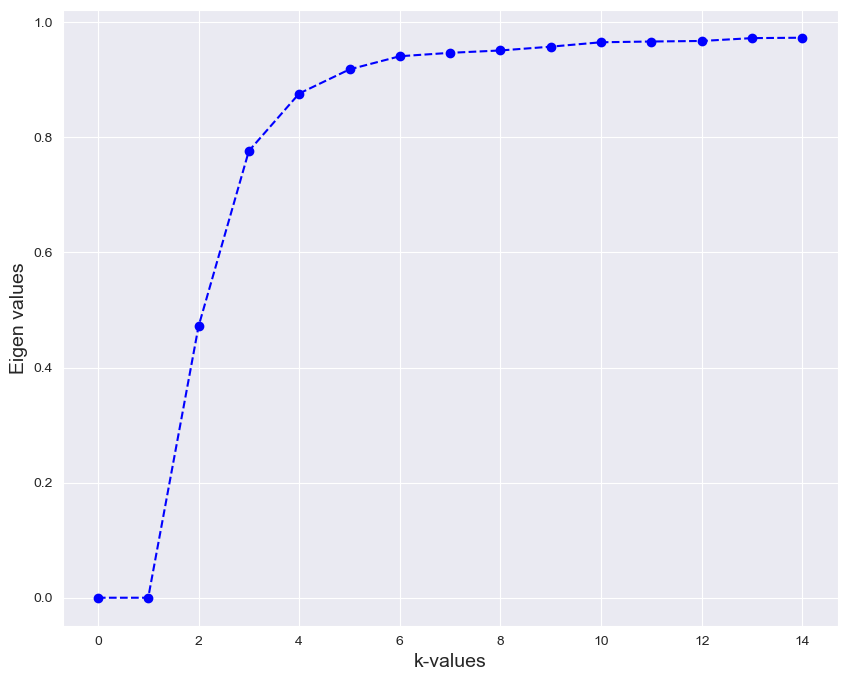

In [ ]:
# Plotting elbow points

plt.figure(figsize=(10, 8))
sns.set_style("darkgrid")

plt.plot(eigen_values, color='b', marker='o', linestyle='--')
plt.xlabel('k-values', fontsize=14)
plt.ylabel('Eigen values', fontsize=14)

### It can be observed from above plot that the first large spectral gap occurs after two points indicating that there exists two clusters in the dataset. This heuristic analysis is confirmed below by computing Mean Square error for different number of clusters. The no. of clusters resulting in lowest MSE is chosen to be the optimum number of clusters.

# 

In [ ]:
# Computing Mean Square Error and finding evidence for optimum no. of clusters

cluster_counts = {}
MSE = {}

cluster_hyperparam = [2, 3, 4, 5, 6, 7]

for clusters in cluster_hyperparam:
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(eigen_vectors[:, 1:clusters])
    
    cluster_labels = kmeans.labels_
    unique, counts = np.unique(cluster_labels, return_counts=True)
    cluster_counts[f"Count dict for {clusters} clusters"] = dict(zip(unique, counts))
    
    MSE[f"For {clusters} clusters"] = np.round(kmeans.inertia_, 6)

In [ ]:
pd.DataFrame(cluster_counts).fillna(0)

,Count dict for 2 clusters,Count dict for 3 clusters,Count dict for 4 clusters,Count dict for 5 clusters,Count dict for 6 clusters,Count dict for 7 clusters
0,1197.0,718.0,711.0,520.0,309.0,237
1,2.0,479.0,3.0,332.0,3.0,3
2,0.0,2.0,483.0,342.0,361.0,317
3,0.0,0.0,2.0,3.0,2.0,291
4,0.0,0.0,0.0,2.0,200.0,145
5,0.0,0.0,0.0,0.0,324.0,2
6,0.0,0.0,0.0,0.0,0.0,204


In [ ]:
MSE

{'For 2 clusters': 0.003411,
 'For 3 clusters': 0.196926,
 'For 4 clusters': 0.250885,
 'For 5 clusters': 0.821753,
 'For 6 clusters': 1.266148,
 'For 7 clusters': 1.67741}

In [ ]:
print(f"Minimum MSE value obtained {min(MSE, key=MSE.get)}")

Minimum MSE value obtained For 2 clusters


### Thus we have obtained evidence for our heuristic analysis of the optimum no. of clusters to be 2. From above result we can see that the max no. of datapoints (1197) belong to cluster 0 while only two datapoints belong to cluster 1. Thus it is highly likely that these two datapoints are outliers. 